In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.lancaster import LancasterStemmer
import numpy as np
import nltk
from scipy.sparse import hstack
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')
# Ensure you have the necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from collections import Counter

# Load the dataset
df = pd.read_csv('spotify_reviews.csv')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df.shape

(84165, 8)

In [3]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


In [4]:
df.describe()

,score,thumbsUpCount
count,84165.000000,84165.000000
mean,2.439696,15.690097
std,1.508838,102.131869
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,4.000000,4.000000
max,5.000000,9781.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84165 entries, 0 to 84164
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              84165 non-null  object
 1   userName              84161 non-null  object
 2   content               84165 non-null  object
 3   score                 84165 non-null  int64 
 4   thumbsUpCount         84165 non-null  int64 
 5   reviewCreatedVersion  78397 non-null  object
 6   at                    84165 non-null  object
 7   appVersion            78397 non-null  object
dtypes: int64(2), object(6)
memory usage: 5.1+ MB


In [6]:
df.isnull().sum()

reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64

In [7]:
df=df.sample(30000)
df=df.reset_index(drop=True)

# data cleaning

In [8]:
# remove extra spaces
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

In [9]:
# remove contractions
contraction = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not'}

def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

In [10]:
# stemming
nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()
def lexicon_normalization(text):
    words = word_tokenize(text)


    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]

    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem


In [11]:
# this function is for text cleaning
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    # Remove twitter handles
    text = re.sub('@[^\s]+','',text)
     # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove hashtags
    text = re.sub(r'\B#\S+','',text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)

    return text

In [12]:
# Remove stop words
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

In [13]:
# tokenize the text
def tokenise(text):
    words = word_tokenize(text)
    return words

In [14]:
import re
df['content_processed']=df['content'].apply(lambda x:clean_text(x))

In [15]:
df['content_processed'] = df['content_processed'].map(lambda x: re.sub(r'\W+', ' ', str(x)))
df['content_processed'] = df['content_processed'].replace(r'\W+', ' ', regex=True)

In [16]:
df['content_processed']=df['content_processed'].apply(lambda x: mapping_replacer(x, contraction))

In [17]:
df['content_processed']=df['content_processed'].apply(lambda x: remove_stopword(x))

# data preprocessing

In [20]:

# Vectorize the preprocessed text
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['content_processed'])



In [21]:
# Normalize the score column
scaler = MinMaxScaler()
X_score = scaler.fit_transform(df[['score']])



In [22]:
# Combine the content feature with the score
X_combined = hstack((X_text, X_score))



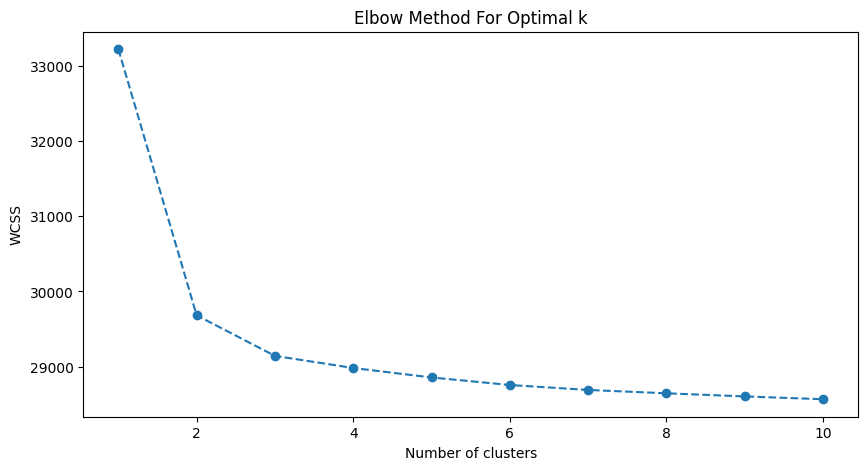

In [23]:
# Choose the number of clusters with the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(X_combined)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method results
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


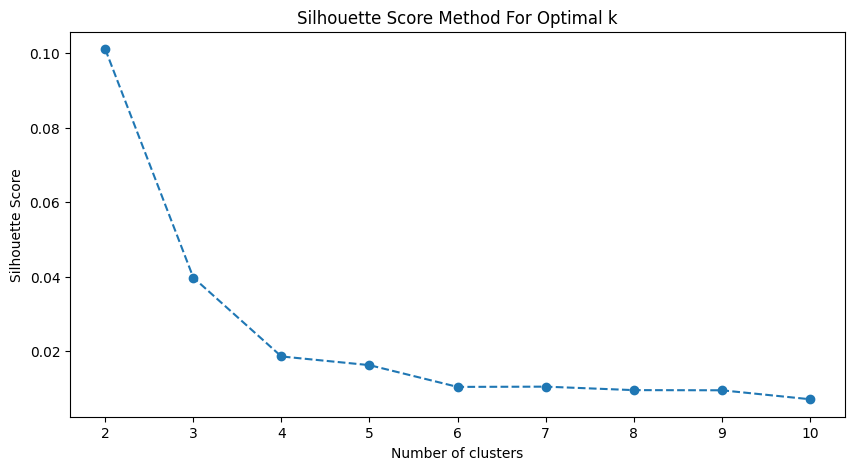

In [24]:
from sklearn.metrics import silhouette_score


silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(X_combined)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_combined, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [25]:

# The elbow is observed at 3 clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters,init='k-means++', random_state=42)

# Fit the clustering model
kmeans.fit(X_combined)

# Assign the clusters to the dataframe
df['cluster'] = kmeans.labels_


In [26]:

# Reduce the dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())


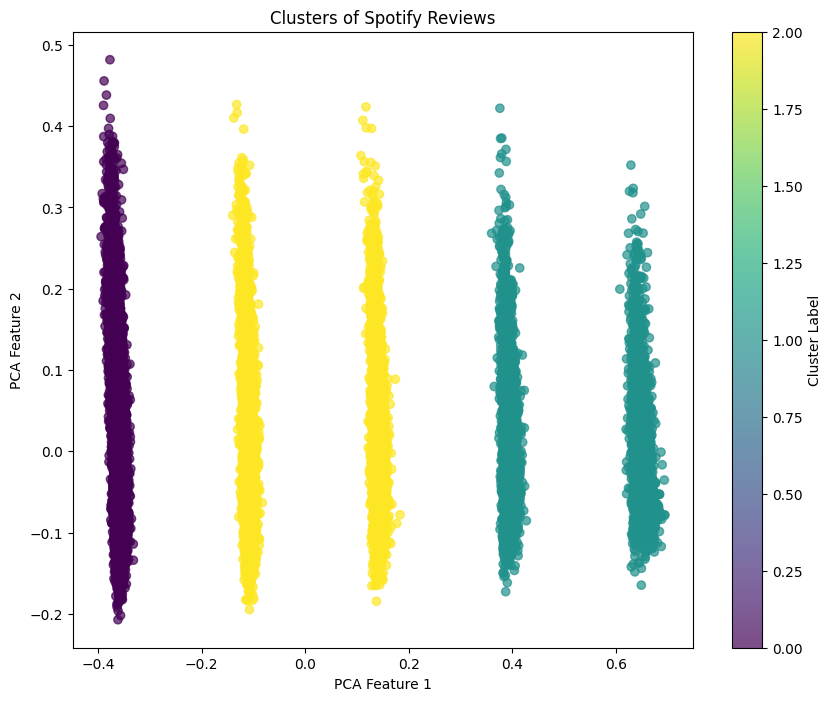

In [27]:

# Scatter plot of the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', marker='o', alpha=0.7)
plt.title('Clusters of Spotify Reviews')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()



# Clustering insights:

In [28]:
# Print out the centroids
print("Cluster centroids: \n")
print(kmeans.cluster_centers_)



Cluster centroids: 

[[3.81216584e-05 0.00000000e+00 2.17064630e-05 ... 0.00000000e+00
  2.50334014e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.90051818e-05 ... 3.30751219e-05
  0.00000000e+00 8.93800507e-01]
 [0.00000000e+00 6.15504749e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.66098901e-01]]


In [29]:
# Analyze the results
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    # Ensure the index is within the bounds of the terms array
    top_indices = order_centroids[i, :10]
    top_indices = top_indices[top_indices < len(terms)]
    top_terms = [terms[ind] for ind in top_indices]
    print("Cluster {}: {}".format(i, ', '.join(top_terms)))

Top terms per cluster:
Cluster 0: app, song, songs, cant, premium, spotify, play, music, even, listen
Cluster 1: music, app, spotify, love, songs, great, good, like, listen
Cluster 2: app, songs, song, music, spotify, play, playlist, like, ads


In [30]:
# Cluster Size
print("Cluster sizes:")
print(df['cluster'].value_counts())



Cluster sizes:
cluster
0    12609
2     9100
1     8291
Name: count, dtype: int64


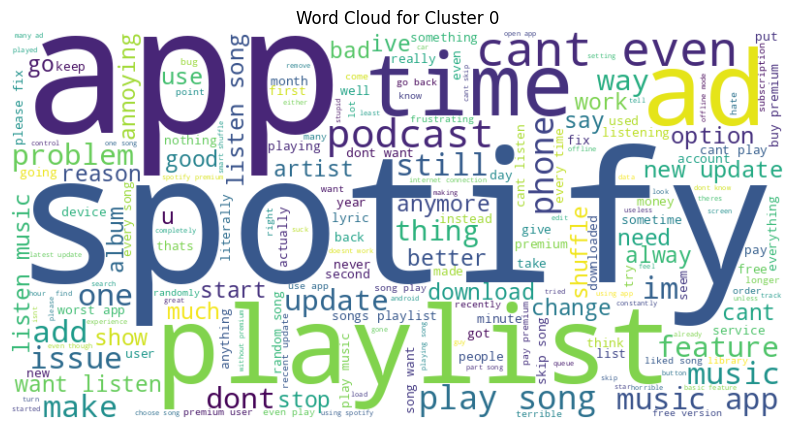

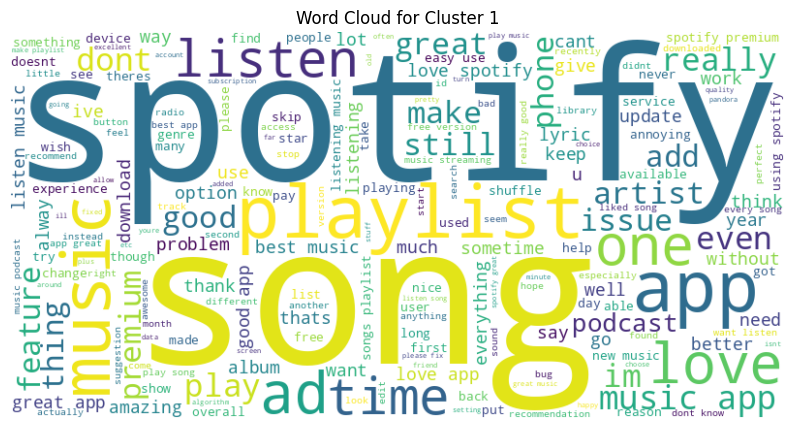

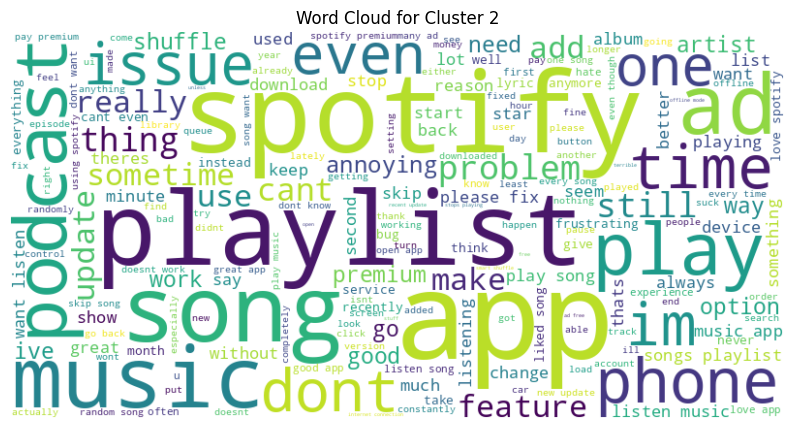

In [31]:
# Word Clouds for each cluster
for i in range(num_clusters):
    plt.figure(figsize=(10, 7))
    cluster_text = " ".join(df.loc[df['cluster'] == i, 'content_processed'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {i}')
    plt.show()


In [32]:

# Cross-tabulation with another feature (if available)
# For example, if there's a 'user_type' column
if 'user_type' in df.columns:
    print(pd.crosstab(df['cluster'], df['user_type']))


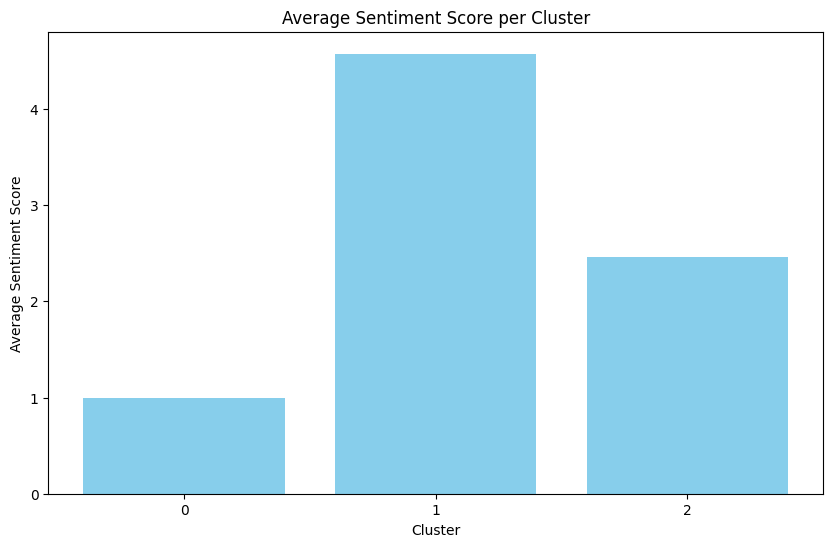

In [33]:
# Calculate the average score per cluster
avg_scores = df.groupby('cluster')['score'].mean().reset_index()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(avg_scores['cluster'], avg_scores['score'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score per Cluster')
plt.xticks(avg_scores['cluster'])
plt.show()

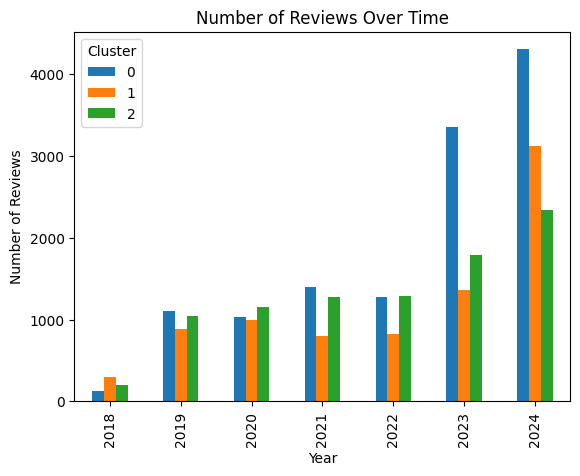

In [36]:
# Temporal Analysis

if 'at' in df.columns:
    df['date'] = pd.to_datetime(df['at'])

    # Extract the year from the date
    df['year'] = df['date'].dt.year

    # Group by year and cluster, then count the occurrences
    yearly_cluster_counts = df.groupby(['year', 'cluster']).size().unstack(fill_value=0)

    # Plot the data
    yearly_cluster_counts.plot(kind='bar', stacked=False)
    plt.title('Number of Reviews Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Cluster')
    plt.show()


# Extracting sentiments from reviews and finding the relationship between clusters and sentiment

In [37]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [38]:
# Initialize the sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()
def vader_sentiment(content):
    scores=sid.polarity_scores(content)
    return scores["pos"],scores["neg"]
df["pos"],df["neg"]=zip(*df["content_processed"].apply(vader_sentiment))

In [39]:
# Function to classify sentiment
def classify_sentiment(pos, neg):
    if pos > neg:
        return "positive"
    else:
        return "negative"

# Apply the function to create the 'sentiment' column
df["sentiment"] = df.apply(lambda row: classify_sentiment(row["pos"], row["neg"]), axis=1)

sentiment  negative  positive
cluster                      
0              6221      6388
1               854      7437
2              2991      6109


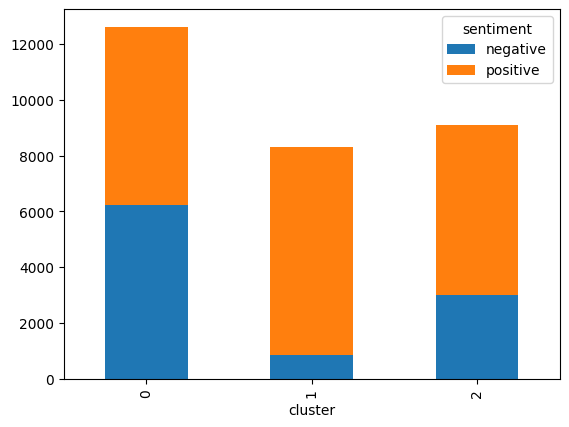

In [40]:
cluster_sentiment = df.groupby(['cluster', 'sentiment']).size().unstack(fill_value=0)
print(cluster_sentiment)

# Optionally, visualize the results
cluster_sentiment.plot(kind='bar', stacked=True)
plt.show()